# Imports and Functions,



In [1]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def preprocess(docs):
  # take in a list of documents and returns a preprocessed list of docs
  lemmatizer = WordNetLemmatizer()
  stemmer = SnowballStemmer('english')
  preprocessed = []

  for doc in docs:
    tokenized = word_tokenize(doc)

    cleaned = [stemmer.stem(lemmatizer.lemmatize(token.lower())) 
                for token in tokenized 
               if token.lower() not in stopwords.words('english') 
               if token.isalpha()]

    untokenized = " ".join(cleaned)

    preprocessed.append(untokenized)

  return preprocessed

# Load saved dataset,

In [4]:
# Read data that has been processed from original data sets into one main df.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Yelp NLP Project/merged_data.csv')

In [5]:
df = df[df['clean_cats'].str.contains(pat = 'restaurant|food')] # only look at food businesses
df.shape

(60811, 15)

In [6]:
# Sample to a smaller size so the data does not crash the kernel
m_df = df.sample(frac = .1, replace = 'disallow')

In [7]:
m_df.shape

(6081, 15)

In [8]:
m_df.head(2)

,review_id,user_id,business_id,text,city,cur_review_star,user_rev_sum,biz_name,user_avg_star,biz_star,biz_rev_sum,rev_fb,clean_cats,star_diff,fb_ratio
25221,LHYBf0D_zY3eOrM9tS9iZQ,3txkO0OBMOqPpqa8KHIAqA,YdlmkxISEW4C1Cx5hXf9nA,My daughter brought me to Melt Bar and Grilled...,Columbus,5.0,20,Melt Bar and Grilled,3.94,3.5,598.0,0,american american bars comfort desserts food f...,0.380711,0.025594
5894,RlioJd1sCc-Bic-qjKeAng,omccsyFBV0nymJTIcbb86g,SLUycy62pnd3ZX-NMPj6tg,"You walk in and they ask ""Chicken or beef?"" My...",Portland,4.0,147,Teo Bun Bo Hue,3.77,4.0,153.0,4,ethnic food food food food imported noodles re...,0.000000,401.000000


## Normalize Text and Create a Binary Feature for Classification Modeling,

In [9]:
# Noramlize the review text
m_df['text_norm'] = preprocess(m_df['text'])

In [10]:
# Create a feature to target the model towards. 

def to_num(x):  # function to transform a column into binary
    return np.where(x == True, 1, 0)

star_mean = m_df['user_avg_star']
m_df['fan'] = to_num(m_df['cur_review_star'] >= star_mean) # Feature that considers if the review text would like the business more or less than the avg person.

print('Is the new feature balanced:', '\nHow many are a fan of the business compared to others? =', len(m_df.fan == 1),'\nHow many are NOT a fan? =', len(m_df.fan == 0))
m_df.fan.value_counts()

Is the new feature balanced: 
How many are a fan of the business compared to others? = 6081 
How many are NOT a fan? = 6081


1    3750
0    2331
Name: fan, dtype: int64

In [11]:
m_df.head(3)

,review_id,user_id,business_id,text,city,cur_review_star,user_rev_sum,biz_name,user_avg_star,biz_star,biz_rev_sum,rev_fb,clean_cats,star_diff,fb_ratio,text_norm,fan
25221,LHYBf0D_zY3eOrM9tS9iZQ,3txkO0OBMOqPpqa8KHIAqA,YdlmkxISEW4C1Cx5hXf9nA,My daughter brought me to Melt Bar and Grilled...,Columbus,5.0,20,Melt Bar and Grilled,3.94,3.5,598.0,0,american american bars comfort desserts food f...,0.380711,0.025594,daughter brought melt bar grill visit let tell...,1
5894,RlioJd1sCc-Bic-qjKeAng,omccsyFBV0nymJTIcbb86g,SLUycy62pnd3ZX-NMPj6tg,"You walk in and they ask ""Chicken or beef?"" My...",Portland,4.0,147,Teo Bun Bo Hue,3.77,4.0,153.0,4,ethnic food food food food imported noodles re...,0.000000,401.000000,walk ask chicken beef husband said beef ask wa...,1
33235,Cfxbmx9KX990R9LX_4pX-Q,hqfcDak2Ne2Nc2p4QavXTw,ETBRfsLs6cLnti5aSddHQw,Went here three weeks ago on a Tuesday night a...,Danvers,4.0,9,Sam & Joe's Restaurant,2.67,3.0,86.0,2,italian pizza restaurants sandwiches seafood,0.374532,5.227135,went three week ago tuesday night night ago th...,1


## Naive Model - Random Forest Classifier,

In [12]:
# Train Test Split > Tfidf Vectorizer > dummy > merge dfs > RandomforetModel > analysis, classication report 

In [13]:
# filter df for X and y to train,test,split.

X = m_df[['text_norm', 'star_diff', 'fb_ratio', 'biz_rev_sum', 'user_rev_sum', 'biz_star']]
y = m_df['fan']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state = 55)

In [14]:
# vectorize normalized text
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['text_norm'])
X_test_vec = vectorizer.transform(X_test['text_norm'])

In [15]:
# Set vectorized text to a df. 

v_df = pd.DataFrame(X_train_vec.toarray(), columns = vectorizer.get_feature_names(), index = X_train.index)
test_v_df = pd.DataFrame(X_test_vec.toarray(), columns = vectorizer.get_feature_names(), index = X_test.index)

In [16]:
con_df = pd.concat([X_train, v_df], axis = 1)
con_df = con_df.drop(columns = 'text_norm') # combine the vectors with the numeric to create a new X_train
#con_df.head(2)

In [17]:
test_df = pd.concat([X_test, test_v_df], axis = 1) # Combine vectors with the numeric for a new test df. 
test_df = test_df.drop(columns = 'text_norm') 
#test_df.head(2)

In [28]:
# Run the model
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(con_df, y_train)

y_pred = clf.predict(test_df)

In [29]:
clf.score(test_df, y_test)

0.8783894823336073

## Analyze the Random Forest Classifier Model

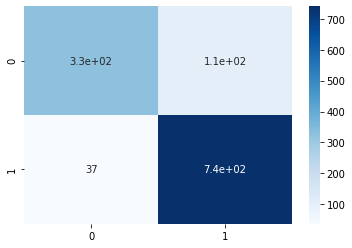

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot = True, cmap = 'Blues')

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       440
           1       0.87      0.95      0.91       777

    accuracy                           0.88      1217
   macro avg       0.88      0.85      0.86      1217
weighted avg       0.88      0.88      0.88      1217



In [22]:
clf.predict(test_df[:5])

array([1, 1, 1, 1, 1])

In [24]:
clf.predict_proba(test_df[:5])

array([[0.16, 0.84],
       [0.13, 0.87],
       [0.17, 0.83],
       [0.23, 0.77],
       [0.42, 0.58]])

### Analysis -- The results of the model are very accurate.

# 2 input 1 output model preprocess,

In [33]:
vocab_size = np.sum(m_df.text_norm.str.len())
vocab_size

1890754

In [ ]:
#cat_size = np.sum(m_df.clean_cats.str.len())
#cat_size

In [34]:
from tensorflow.keras.preprocessing.text import one_hot

m_df['text_encoded'] = m_df.text_norm.apply(one_hot, args = [vocab_size]) # one hot encode the vocabulary
# m_df['cat_encoded'] = m_df.clean_cats.apply(one_hot, args = [cat_size])
m_df.head(2)

,review_id,user_id,business_id,text,city,cur_review_star,user_rev_sum,biz_name,user_avg_star,biz_star,biz_rev_sum,rev_fb,clean_cats,star_diff,fb_ratio,text_norm,fan,text_encoded
25221,LHYBf0D_zY3eOrM9tS9iZQ,3txkO0OBMOqPpqa8KHIAqA,YdlmkxISEW4C1Cx5hXf9nA,My daughter brought me to Melt Bar and Grilled...,Columbus,5.0,20,Melt Bar and Grilled,3.94,3.5,598.0,0,american american bars comfort desserts food f...,0.380711,0.025594,daughter brought melt bar grill visit let tell...,1,"[264494, 1350703, 568468, 1176831, 1751727, 32..."
5894,RlioJd1sCc-Bic-qjKeAng,omccsyFBV0nymJTIcbb86g,SLUycy62pnd3ZX-NMPj6tg,"You walk in and they ask ""Chicken or beef?"" My...",Portland,4.0,147,Teo Bun Bo Hue,3.77,4.0,153.0,4,ethnic food food food food imported noodles re...,0.000000,401.000000,walk ask chicken beef husband said beef ask wa...,1,"[1800576, 71918, 256214, 754473, 1012266, 3944..."


In [35]:
ind_vars = pad_sequences(m_df.text_encoded.values)  # pad docs to make the same size and prep for modeling. 
# cat_vars = pad_sequences(m_df.cat_encoded.values)
# print(cat_vars)
ind_vars

array([[      0,       0,       0, ...,  264494,  330719, 1086881],
       [      0,       0,       0, ..., 1528005,  893281,  674760],
       [      0,       0,       0, ...,  591007,  591007, 1704034],
       ...,
       [      0,       0,       0, ...,  519270,  159491,  230322],
       [      0,       0,       0, ...,  352576, 1537566, 1172570],
       [      0,       0,       0, ...,  815717,  703155,  330719]],
      dtype=int32)

In [36]:
len(ind_vars[1])

469

In [37]:
# Features to model
model_df = m_df[[
                 'cur_review_star',
                 'user_avg_star',
                 'biz_rev_sum',
                 'user_rev_sum',
                 'biz_star',
                 'fb_ratio',
                 'star_diff',
                 'fan'
                 ]]

In [38]:
model_df.head()

,cur_review_star,user_avg_star,biz_rev_sum,user_rev_sum,biz_star,fb_ratio,star_diff,fan
25221,5.0,3.94,598.0,20,3.5,0.025594,0.380711,1
5894,4.0,3.77,153.0,147,4.0,401.000000,0.000000,1
33235,4.0,2.67,86.0,9,3.0,5.227135,0.374532,1
70513,5.0,5.00,190.0,4,4.0,4.809524,0.200000,1
68481,5.0,3.65,6.0,36,4.0,3.556681,0.273973,1


In [39]:
# Get dummies on the less granular features.

#mod_dummy = pd.get_dummies(model_df, columns = ['cur_review_star', 'biz_star'], drop_first = True)
mod_dummy = pd.get_dummies(model_df, columns = ['cur_review_star'], drop_first = True)

mod_dummy = mod_dummy.reset_index()

In [40]:
mod_dummy = mod_dummy.drop(columns = 'index', errors = 'ignore')
mod_dummy.head()

,user_avg_star,biz_rev_sum,user_rev_sum,biz_star,fb_ratio,star_diff,fan,cur_review_star_2.0,cur_review_star_3.0,cur_review_star_4.0,cur_review_star_5.0
0,3.94,598.0,20,3.5,0.025594,0.380711,1,0,0,0,1
1,3.77,153.0,147,4.0,401.000000,0.000000,1,0,0,1,0
2,2.67,86.0,9,3.0,5.227135,0.374532,1,0,0,1,0
3,5.00,190.0,4,4.0,4.809524,0.200000,1,0,0,0,1
4,3.65,6.0,36,4.0,3.556681,0.273973,1,0,0,0,1


In [41]:
mod_dummy.dtypes

user_avg_star          float64
biz_rev_sum            float64
user_rev_sum             int64
biz_star               float64
fb_ratio               float64
star_diff              float64
fan                      int64
cur_review_star_2.0      uint8
cur_review_star_3.0      uint8
cur_review_star_4.0      uint8
cur_review_star_5.0      uint8
dtype: object

In [42]:
from sklearn.preprocessing import MinMaxScaler
#Scaling the dummies, also tried with out doing dummies, results were lower quality.

cols = [x for x in mod_dummy.columns if x != 'fan']
scaler = MinMaxScaler()
scaler.fit(mod_dummy[cols])
predictor_scaled = scaler.transform(mod_dummy[cols])


In [43]:
# shape of the text vector data
ind_vars.shape

(6081, 469)

In [44]:
# shape of the numeric data
predictor_scaled.shape

(6081, 10)

## Begin Modeling,

In [45]:
# define target variable
target = model_df['fan']

ind_df = pd.DataFrame(ind_vars)
ind_cols = ind_df.shape[1] # how many columns is the ind vars df. 
pred_scaled_df = pd.DataFrame(predictor_scaled)

# combine both dataframes to split them
combined_df = pd.concat([ind_df, pred_scaled_df], axis = 1)

In [46]:
# splits data
X_train, X_test, y_train, y_test = train_test_split(combined_df, target, test_size = .2, random_state = 55)

In [47]:
X_train_ind = X_train.iloc[:, :ind_cols].values # slice to split the columns
X_train_pred = X_train.iloc[:, ind_cols:].values

X_test_ind = X_test.iloc[:, :ind_cols].values # slice to split the columns
X_test_pred = X_test.iloc[:,ind_cols:].values


In [48]:
max_words = np.max(X_train_ind) +1
num_class = 1
max_len = X_train_ind.shape[1]

In [49]:
# first branch
input_layer1 = Input(shape=(X_train_pred.shape[1],))
dense11 = Dense(32, activation="relu")(input_layer1)
dense12 = Dense(32, activation="relu")(dense11)

# second branch
input_layer2 = Input(shape=(X_train_ind.shape[1],))
embed1 = Embedding(max_words, 150, input_length=max_len)(input_layer2)
lstm1 = LSTM(32)(embed1)
dense21 = Dense(32, activation="relu")(lstm1)

# merge inputs
merge = concatenate([dense12, dense21])

output = Dense(1,activation = 'sigmoid')(merge)

model = Model(inputs=[input_layer1, input_layer2], outputs=output)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [50]:
epochs = 5
batch_size = 128

history = model.fit([X_train_pred, X_train_ind], y_train, validation_data=([X_test_pred, X_test_ind], y_test),
          batch_size=batch_size, epochs=epochs)

Epoch 1/5
38/38 [==============================] - 81s 2s/step - loss: 0.6264 - accuracy: 0.6085 - val_loss: 0.4945 - val_accuracy: 0.8176
Epoch 2/5
38/38 [==============================] - 59s 2s/step - loss: 0.4218 - accuracy: 0.8365 - val_loss: 0.3840 - val_accuracy: 0.8422
Epoch 3/5
38/38 [==============================] - 59s 2s/step - loss: 0.2386 - accuracy: 0.9122 - val_loss: 0.4360 - val_accuracy: 0.7987
Epoch 4/5
38/38 [==============================] - 59s 2s/step - loss: 0.1203 - accuracy: 0.9629 - val_loss: 0.5117 - val_accuracy: 0.7855
Epoch 5/5
38/38 [==============================] - 59s 2s/step - loss: 0.0677 - accuracy: 0.9827 - val_loss: 0.6038 - val_accuracy: 0.7765


In [51]:
history_df = pd.DataFrame(history.history)

Text(0, 0.5, 'Loss')

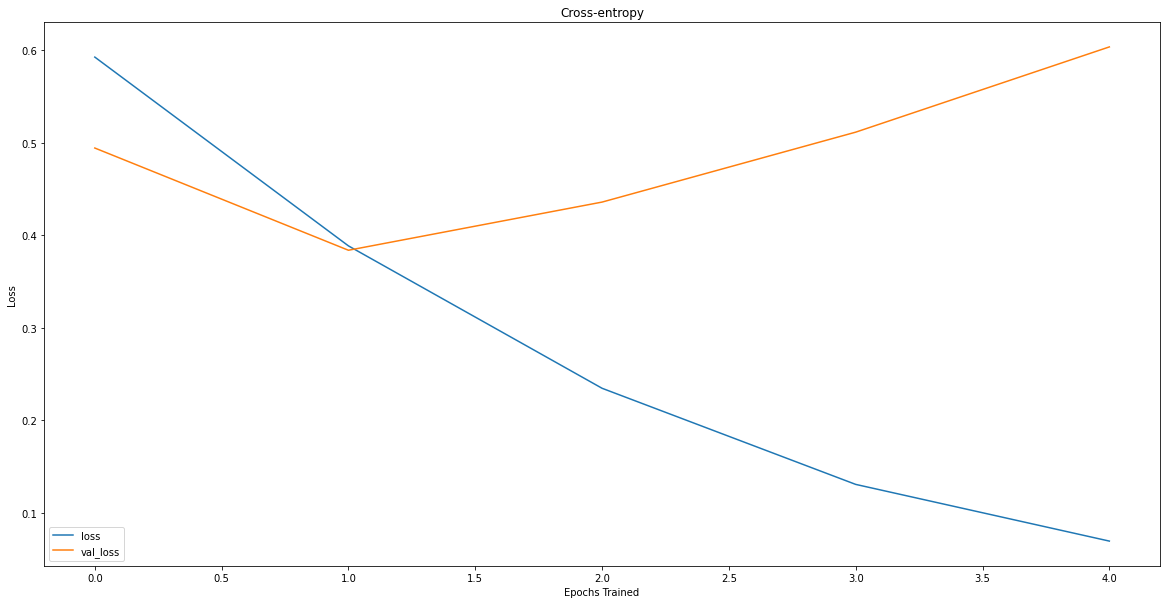

In [52]:
# plot the loss vs val loss
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy", figsize=(20, 10))
plt.xlabel('Epochs Trained')
plt.ylabel('Loss')

In [ ]:
# plot the accuracy vs val accuracy
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Cross-entropy", figsize=(20, 10))
plt.xlabel('Epochs Trained')
plt.ylabel('Accuracy Score')

In [53]:
preds = model.predict([X_test_pred, X_test_ind])
pred_df = pd.DataFrame(preds, columns = ['predictions'])

pred_df.describe()

,predictions
count,1217.000000
mean,0.598405
std,0.424219
min,0.000489
25%,0.063555
50%,0.852077
75%,0.994638
max,0.999944


In [92]:
def grade_star(x): # Create a star value based on predicted probability of how much a business was liked.  
  if x > .9995:
    return 5
  elif x >= .999:
    return 4.5
  elif x >= .995:
    return 4
  elif x >= .95:
    return 3.5
  elif x >= .5:
    return 3
  elif x >= .04:
    return 2.5
  elif x >= .0045:
    return 2
  elif x >= .003:
    return 1.5
  else:
    return 1

In [93]:
# build a column that gives a ML generate star prediciton.
pred_df['star'] = pred_df['predictions'].apply(grade_star)

In [94]:
pred_df.star.value_counts()

3.0    224
2.5    220
3.5    208
2.0    188
4.0    162
5.0     81
4.5     56
1.0     52
1.5     26
Name: star, dtype: int64

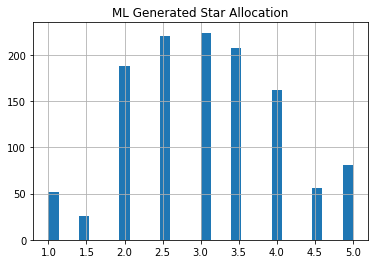

In [95]:
# check the new star distribution.
pred_df.star.hist(bins = 30)
plt.title('ML Generated Star Allocation')
plt.show()

In [96]:
preds[:5] # examples of the predictions.  

array([[0.9946378 ],
       [0.99935395],
       [0.9973447 ],
       [0.9991393 ],
       [0.6798449 ]], dtype=float32)

# To - do 

Loss graph. 

How did I get the data, domain? 
Approach - cleaning, feature engineering - 
showcase eda to justify choices 
models used. 

Maybe show a naive model as a base. 



In [ ]:
# Next step, build pipeline to process incoming data for production into the model. 
  # format new data the same way and then pass through model. 

# def new_data_process(data): 
#   process = normalize(data.text)
#   encoded = 
#   padded = 
#   return [ind_vars, predictor]

In [ ]:
model.save('mymodel.h5') # save model architecture and weights
  

In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
test_model = load_model('/content/mymodel.h5')

In [ ]:
test_model.summary()

In [ ]:
test_model.predict([X_test_pred[11].reshape(1,-1),X_test_ind[11].reshape(1,-1)]) # for 1 row predictions. 

In [ ]:
df.sample(1)